### Import Packages

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emf_fxns_2 as emf
import os

### file path to dataset containing cleaned updated results

In [46]:
fp = "~/OneDrive - NREL/EMF-37 - Lamers, Patrick's files/lwachs/"
data_file_name = 'cleaned_emf_data_usa_apr_23.csv'
date = 'may23'
Output_graphic_directory = date + '/figs/'
Output_file_directory = date + '/files/'


### If you are making the directories for figs and files for the first time, run the following commands:

In [47]:
# os.makedirs(Output_file_directory)
# os.makedirs(Output_graphic_directory)

### Open data file as dataframe

In [48]:
df = pd.read_csv(fp+data_file_name, usecols= list(range(1,9)))

# a prior version of the dataset contained USA, Canada, and Mexico. We are using just US data.
# df.query('region == "United States"', inplace = True)
# df.reset_index(drop = True, inplace = True)

#### Create new dataframe containing data with variables that have Biomass OR Biogas in variable string name

In [49]:
df_bio = (df[df['variable'].str.contains('Biomass|Biogas', case=False)])
df_bio.reset_index(drop = True, inplace = True)

In [50]:
df_bio['model'].unique()

array(['ADAGE', 'AEO2020', 'AEO2021', 'AEO2022', 'AnyMOD', 'DIEM',
       'EC-MSMR', 'EIA_Historic', 'EIA_STEO', 'ENERGY2020', 'EP-RIO',
       'EPA-TIMES', 'EPS', 'FARM', 'FECM-NEMS', 'GCAM', 'GCAM-USA',
       'MA3T', 'MARKAL-NETL', 'MER', 'NATEM', 'NREL-TDA', 'ReEDS',
       'Scout', 'TEMOA', 'TEMPO', 'US-REGEN', 'USREP-ReEDS', 'gTech'],
      dtype=object)

### Creating bioenergy dataframe for only cross sectoral Final Energy

In [51]:
dfb_fn = df_bio[df_bio['variable'].str.contains('Final Energy|Secondary Energy|Electricity', case=False) & df_bio['unit'].str.contains('EJ/yr', case=False)]

dfb_fn.reset_index(drop = True, inplace = True)
print(dfb_fn.head())

   model     scenario   unit  year              datasrc  \
0  ADAGE  0by50.CMSG4  EJ/yr  2010  emf37_usacanmex.csv   
1  ADAGE  0by50.CMSG4  EJ/yr  2010  emf37_usacanmex.csv   
2  ADAGE  0by50.CMSG4  EJ/yr  2010  emf37_usacanmex.csv   
3  ADAGE  0by50.CMSG4  EJ/yr  2010  emf37_usacanmex.csv   
4  ADAGE  0by50.CMSG4  EJ/yr  2010  emf37_usacanmex.csv   

                                            variable         region  value  
0                       Final Energy|Biomass Liquids  United States   1.10  
1                        Final Energy|Biomass Solids  United States   0.23  
2        Final Energy|Transportation|Biomass Liquids  United States   1.10  
3  Final Energy|Transportation|Freight|Biomass Li...  United States   0.00  
4  Final Energy|Transportation|Freight|Road|Bioma...  United States   0.00  


### Define dataframes for sectoral breakdown
##### We will need to break the transportation df down further based on what is needed to accomplish for the model

In [52]:
dfb_e = dfb_fn[dfb_fn['variable'].str.contains('Secondary Energy|Electricity', case=False)]
dfb_e.reset_index(drop=True, inplace=True)
dfb_t = dfb_fn[dfb_fn['variable'].str.contains('transportation', case=False)]
dfb_t.reset_index(drop=True, inplace=True)
dfb_b = dfb_fn[dfb_fn['variable'].str.contains('buildings', case=False)]
dfb_b.reset_index(drop=True, inplace=True)
dfb_i = dfb_fn[dfb_fn['variable'].str.contains('industry', case=False)]
dfb_i.reset_index(drop=True, inplace=True)

#### It's nice to export them into a spreadsheet as a resource

In [53]:
# dfb_e.to_excel(Output_file_directory + 'df_electricity.xlsx')
# dfb_t.to_excel(Output_file_directory + 'df_transport.xlsx')
# dfb_b.to_excel(Output_file_directory + 'df_buildings.xlsx')
# dfb_i.to_excel(Output_file_directory + 'df_industry.xlsx')

### Define master dataframe variable for specialized pivot function. This master variable must be present in the models for them to be included. This is demonstrated with transportation as the master variable. 
### Pick scenario to study.

In [54]:
df_m = dfb_t
scenario = '0by50.Ref'

### Run pivot function on each sector being studied. 

In [55]:
data_electric = emf.emf(dfb_e, df_m, scenario, 'Secondary Energy|Electricity|Biomass', 'x', 'y', 'Electricity')
data_transport = emf.emf(dfb_t, df_m, scenario, 'Final Energy|Transportation|Biomass Solids', 'Final Energy|Transportation|Biomass Liquids', 'Final Energy|Transportation|Biogas', 'Transportation')
data_building = emf.emf(dfb_b, df_m, scenario, 'Final Energy|Buildings|Biomass Solids', 'Final Energy|Buildings|Biomass Liquids', 'Final Energy|Buildings|Biogas', 'Buildings')
data_industry = emf.emf(dfb_i, df_m, scenario, 'Final Energy|Industry|Biomass Solids', 'Final Energy|Industry|Biomass Liquids', 'Final Energy|Industry|Biogas', 'Industry')

### Sum up the dataframes to make sure everything is working properly. If one of these is 0 we should check and make sure there weren't any issues

In [56]:
print(data_electric['Bioenergy Electricity'].sum())
print(data_transport['Bioenergy Transportation'].sum())
print(data_building['Bioenergy Buildings'].sum())
print(data_industry['Bioenergy Industry'].sum())

89.08
348.0400000000001
71.54999999999998
267.3


#### Export pivoted files to excel if desired

In [57]:
# data_transport.to_excel(Output_file_directory + 'df_t.xlsx')
# data_building.to_excel(Output_file_directory + 'df_b.xlsx')
# data_electric.to_excel(Output_file_directory + 'df_e.xlsx')
# data_industry.to_excel(Output_file_directory + 'df_i.xlsx')

### Here we are creating a final dataframe which contains the sum of bioenergy calculated above in all sectors. The data is the pivoted data, so corresponds to a single scenario. amd transport has been selected as the main end use sector.

In [58]:
data_cross = pd.DataFrame()
data_cross['model'] = data_transport['model']
data_cross['year'] = data_transport['year']
data_cross['Bioenergy Across Sectors'] =  data_electric['Bioenergy Electricity'] + data_transport['Bioenergy Transportation'] + data_building['Bioenergy Buildings'] + data_industry['Bioenergy Industry']
print(data_cross.head())

# data_cross.to_excel(Output_file_directory + 'data_cross.xlsx')

   model  year  Bioenergy Across Sectors
0  ADAGE  2010                      1.33
1  ADAGE  2015                      1.81
2  ADAGE  2020                      1.92
3  ADAGE  2025                      1.88
4  ADAGE  2030                      1.71


### Plot electricity from bioenergy over time for scenario chosen above.

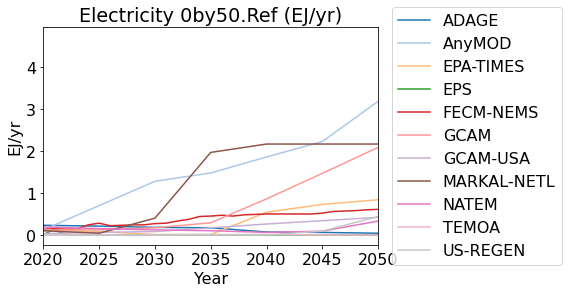

In [59]:
emf.figs(data_electric, 'Bioenergy Electricity', 'Electricity '+scenario)
# plt.savefig(Output_graphic_directory + scenario + '_electric.png', bbox_inches='tight', dpi=300) 
plt.show()

### Plot transportation from bioenergy over time for scenario chosen above.

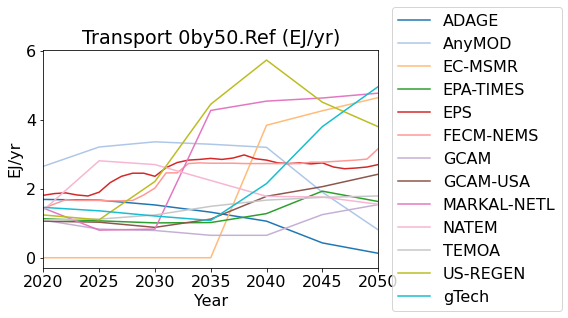

In [60]:
emf.figs(data_transport, 'Bioenergy Transportation', 'Transport '+scenario)
plt.savefig(Output_graphic_directory + scenario + '_transport.png', bbox_inches='tight', dpi=300) 
#plt.show()

### Plot building energy from bioenergy over time for scenario chosen above.

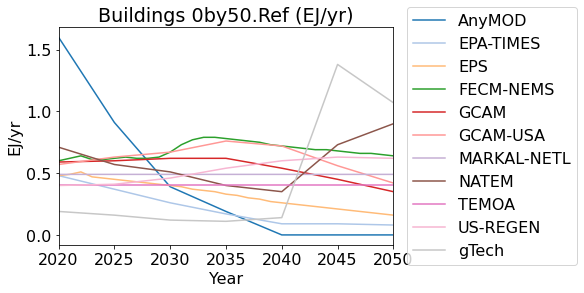

In [61]:
emf.figs(data_building, 'Bioenergy Buildings', 'Buildings '+scenario)
plt.savefig(Output_graphic_directory + scenario + '_buildings.png', bbox_inches='tight', dpi=300) 
#plt.show()

### Plot industry energy from bioenergy over time for scenario chosen above.

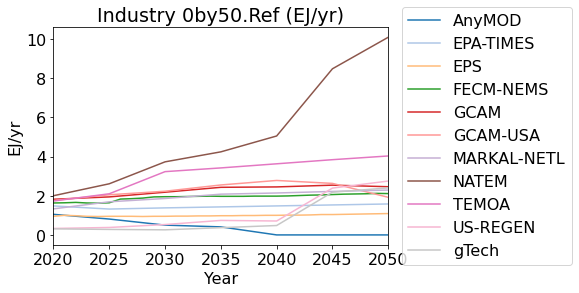

In [62]:
emf.figs(data_industry, 'Bioenergy Industry', 'Industry '+scenario)
plt.savefig(Output_graphic_directory + scenario + '_industry.png', bbox_inches='tight', dpi=300) 

### Plot total bioenergy over time for scenario chosen above.

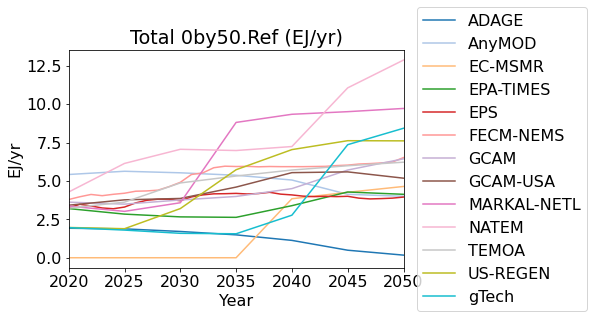

In [63]:
emf.figs(data_cross, 'Bioenergy Across Sectors', 'Total '+scenario)
plt.savefig(Output_graphic_directory + scenario + '_total.png', bbox_inches='tight', dpi=300) 

# Cross Sectoral Bar Chart

### First we will create a dataframe containing all the data we are using from what was developed in function 1

In [64]:

dffb = pd.DataFrame()
dffb['model'] = data_transport['model']
dffb['year'] = data_transport['year']
dffb['electricity'] = data_electric['Bioenergy Electricity']
dffb['transport'] = data_transport['Bioenergy Transportation']
dffb['buildings'] = data_building['Bioenergy Buildings']
dffb['industry'] = data_industry['Bioenergy Industry']


### Make the bar chart - by model and by year

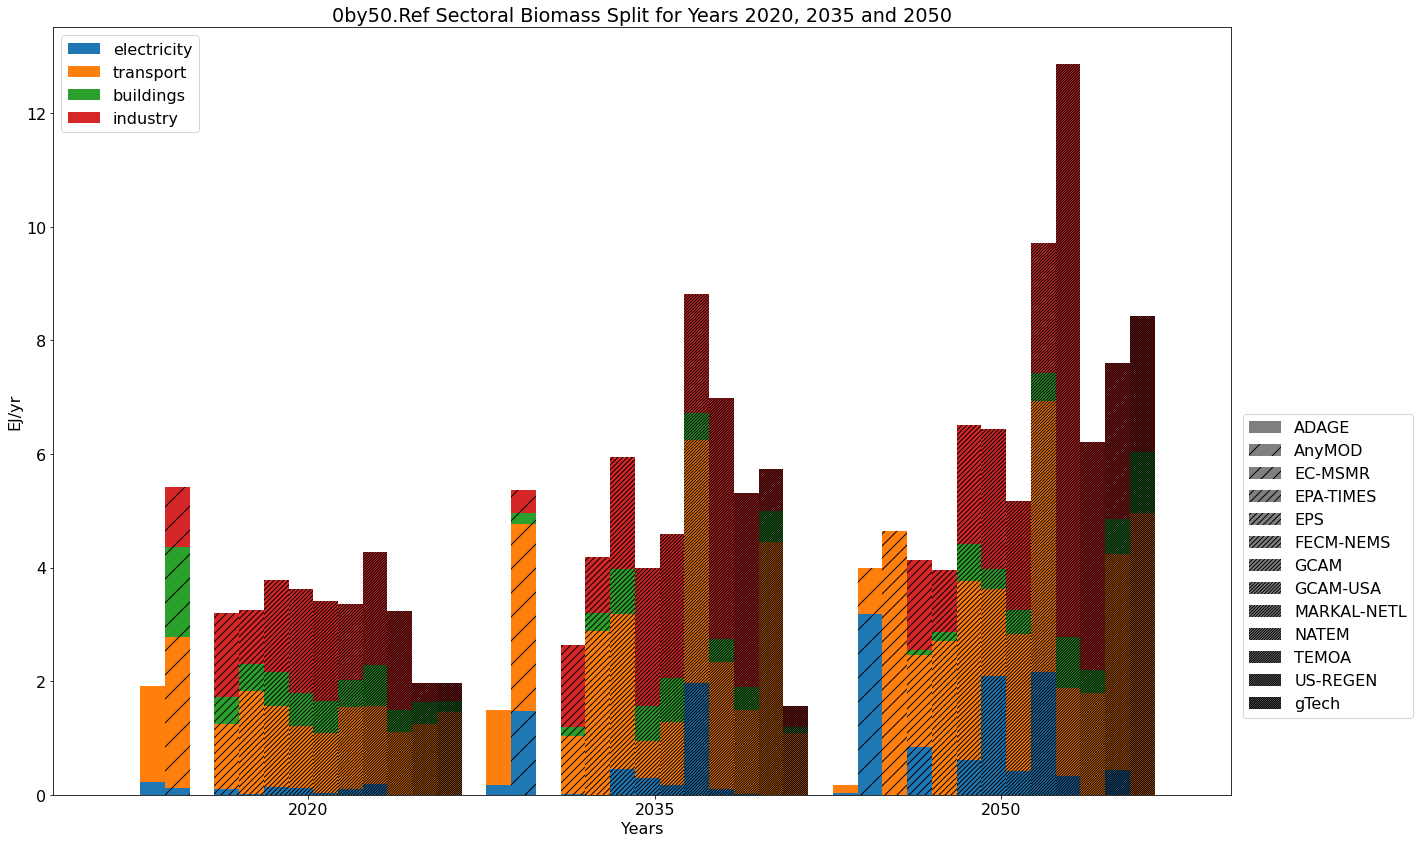

In [65]:
# exclude models with only zero values
for models in list(dffb.model.unique()):
    a = []
    i = 0
    for cols in ['electricity', 'transport', 'buildings', 'industry']:
        a.append(dffb.loc[dffb['model'] == models, cols].sum())
    #    i = i + 1
    #    print(a, i)
    if sum(a) == 0:
        dffb = dffb[dffb.model != models]

# make bar charts
# emf.stacked_bar_by_model(dffb, scenario)
import matplotlib as mpl
mpl.rcParams['font.size']=16
emf.plot_clustered_stacked(dffb, scenario, ' Sectoral Biomass Split for Years 2020, 2035 and 2050')
plt.savefig(Output_graphic_directory + scenario + '_sectoral_biomass_split.svg', bbox_inches='tight')

### If you want to save final dataframe

In [66]:
dffb.to_excel(Output_file_directory + 'dffb_' + scenario + '.xlsx')